In [27]:
%matplotlib inline
#%pylab
import os
import matplotlib, commands
import matplotlib.pyplot as plt
import matplotlib.colors as mpc
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scipy
import scipy.stats
from scipy import interpolate
import pandas as pd
import itertools

In [28]:
# Define globals
### network name <=> data file mapping
_FILEMAP_={'vgg16a' : 'sp_vgg16a_iter_',
           'vgg16b' : 'sp_vgg16b_iter_',
           'vgg16c' : 'sp_vgg16c_iter_',
           'resnet14b'    : 'sp_resnet14b_iter_',
           'resnet14b_w4' : 'sp_resnet14b_w4_iter_',
           'resnet29b'    : 'sp_resnet29b_iter_',
           'resnet29b_w2' : 'sp_resnet29b_w2_iter_',
           'resnet29b_w4' : 'sp_resnet29b_w4_iter_',
           'resnet50b'    : 'sp_resnet50b_iter_',
           'plainresnet10b'    : 'sp_plainresnet10b_iter_',
           'plainresnet10b_w4' : 'sp_plainresnet10b_w4_iter_',
           'plainresnet12b'    : 'sp_plainresnet12b_iter_',
           'plainresnet18b'    : 'sp_plainresnet18b_iter_',
           'plainresnet18b_w4' : 'sp_plainresnet18b_w4_iter_',
           'plainresnet20b'    : 'sp_plainresnet20b_iter_',
           'plainresnet20b_w4' : 'sp_plainresnet20b_w4_iter_'
          }
_DATAMAP_={}
_FILEDIR_='testA'
_LABELS_=['eminus','gamma','muminus','piminus','proton']

In [29]:
def list_itr(netname):
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    f = _FILEDIR_ + '/' + _FILEMAP_[netname]
    itr_v = [int(f.rstrip('.csv').split('_')[-1]) for f in commands.getoutput('ls %s*csv' % f).split() if f.endswith('csv')]
    itr_v.sort()
    return itr_v

def get_df(netname,itr):
    key=(netname,itr)
    if key in _DATAMAP_:
        return _DATAMAP_[key]
    
    if not netname in _FILEMAP_:
        print 'Network not recognized:',netname
        return None
    
    itr_v = list_itr(netname)
    if not itr in itr_v:
        print 'Iteration',itr,'not found'
        return None

    f = _FILEDIR_ + '/' + _FILEMAP_[netname] + str(itr) + '.csv'
    if not os.path.isfile(f):
        print 'LOGIC ERROR ... file not found (should not happen):',f
        return None
    
    df = pd.read_csv(f)
    _DATAMAP_[key] = df
    return _DATAMAP_[key]

def get_accuracy(netname,labels,names):
    if not len(labels) == len(names):
        print '# labels and # names do not match...'
        return None
    for label in labels:
        if not type(label) == type(list()):
            print 'Labels must be of list type'
            return None
        
    # Report available list of iterations
    itr_v = list_itr(netname)
    print 'Iterations',itr_v
    print

    res = {'all_combined':[]}
    for name in names:
        res[name] = []

    # Loop over iterations and print accuracy
    for itr in itr_v:
        # Get data frame
        df = get_df(netname,itr)

        # Compute overall accuracy
        numerator = ''
        for label in labels:
            if numerator: numerator += ' or '
            numerator += '((label in %s) and (prediction in %s))' % (str(label),str(label))
        denominator = ''
        for label in labels:
            if denominator: denominator += ' or '
            denominator += '(label in %s)' % str(label)

        total = float(len(df.query(denominator)))
        acc = 0.
        if total > 0.:
            acc = len(df.query(numerator)) / total
        acc = int(acc*10000)/100.
        res['all_combined'].append(acc)

        # compute per-label accuracy
        for idx in xrange(len(labels)):
            label = labels[idx]
            name  = str(names[idx])
            numerator   = '((label in %s) and (prediction in %s))' % (str(label),str(label))
            denominator = '(label in %s)' % str(label)
            total = float(len(df.query(denominator)))
            acc = 0.
            if total >= 1.:
                acc = len(df.query(numerator)) / total
            acc = int(acc*10000/100.)
            res[name].append(acc)
    
    res['Iteration'] = itr_v
    res = pd.DataFrame(res)
    return res


In [ ]:
#
# Analysis: try printing accuracy per iteration
#

#
# Configurations
#
# network name
netname='resnet29b'

# Report network name
print 'Network',netname
print

# Report available list of iterations
itr_v = list_itr(netname)
print 'Iterations',itr_v
print

res={'all_combined':[]}
for l in _LABELS_:
    res[l]=[]
    res['%s_ctr' % l]=[]

eff_map={}
pur_map={}
# Loop over iterations and print accuracy
for itr in itr_v:
    # Get data frame
    df = get_df(netname,itr)
    
    eminus_df = df.query('label==0')
    gamma_df  = df.query('label==1')
    eminus_data = np.array(eminus_df.eminus.values, dtype='float')
    gamma_data  = np.array(gamma_df.eminus.values,  dtype='float')
    
    efficiency = []
    purity = [] 
        
    for x in xrange(19):
        score_threshold = 0.05 + x*0.05
        num_selected_eminus = len(eminus_df.query('eminus/(eminus+gamma) > %g' % score_threshold))
        num_selected_gamma  = len(gamma_df.query('eminus/(eminus+gamma) > %g' % score_threshold))
        efficiency.append(float(num_selected_eminus) / len(eminus_data))
        purity.append(1 - float(num_selected_gamma) / len(gamma_data)) 
        
    eff_map[itr] = efficiency
    pur_map[itr] = purity
    
    #print df.head() 
    # Compute overall accuracy
    acc = len(df.query('label==prediction')) / float(len(df))
    acc = int(acc*10000)/100.
    res['all_combined'].append(acc)
    
    # Compute per-particle accuracy
    for idx in xrange(len(_LABELS_)):
        label = _LABELS_[idx]
        total = float(len(df.query('label==%d' % idx)))
        res['%s_ctr' % label].append(total)
        
        if total<1.:
            res[label].append(0.)
        else:
            acc = len(df.query('label==prediction and label==%d' % idx)) / total
            acc = int(acc*10000)/100.
            res[label].append(acc)

res['Iteration'] = itr_v
res = pd.DataFrame(res)

# print result
print 'Result:'
print res
print

fig, ax = plt.subplots(figsize=(10, 8),facecolor='w')
for netkey in itr_v:
    plt.plot(pur_map[netkey],eff_map[netkey],marker='o',label="Iter %f" %netkey) #,color=color,label=netkey)
    
plt.tick_params(labelsize=20)
plt.grid()
plt.ylabel('Efficiency',fontsize=20,fontweight='bold')
plt.xlabel('Purity',fontsize=20,fontweight='bold')
plt.legend(fontsize=20,loc='center left', bbox_to_anchor=(1, 0.5))
#leg_frame=leg.get_frame()
#leg_frame.set_facecolor('white')
plt.title('Electron Selection Efficiency/Purity',fontsize=24,fontweight='bold')
plt.show() 

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')
plt.plot(res.Iteration.values,res.eminus.values,label='eminus',marker='o')
plt.plot(res.Iteration.values,res.gamma.values,label='gamma',marker='o')
plt.plot(res.Iteration.values,res.muminus.values,label='muminus',marker='o')
plt.plot(res.Iteration.values,res.piminus.values,label='piminus',marker='o')
plt.plot(res.Iteration.values,res.proton.values,label='proton',marker='o')
leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,90)
plt.show()

Network resnet50b

Iterations [314250, 314500, 314750, 315000, 315250, 315500, 315750, 316000, 316250, 316500, 316750, 317000, 317250, 317500, 317750, 318000, 318250, 318500, 318750, 319000, 319250, 319500, 319750]

Result:
    Iteration  all_combined  shower  track
0      314250         99.05      98     99
1      314500         99.01      99     98
2      314750         98.99      98     99
3      315000         99.04      98     99
4      315250         98.76      97     99
5      315500        100.00     100      0
6      315750        100.00     100      0
7      316000        100.00     100      0
8      316250         98.98      98     99
9      316500        100.00     100      0
10     316750         98.64      97     99
11     317000        100.00     100      0
12     317250         98.90      99     98
13     317500         99.05      98     99
14     317750         98.92      98     99
15     318000         98.56      97     99
16     318250         98.97      98     99
17

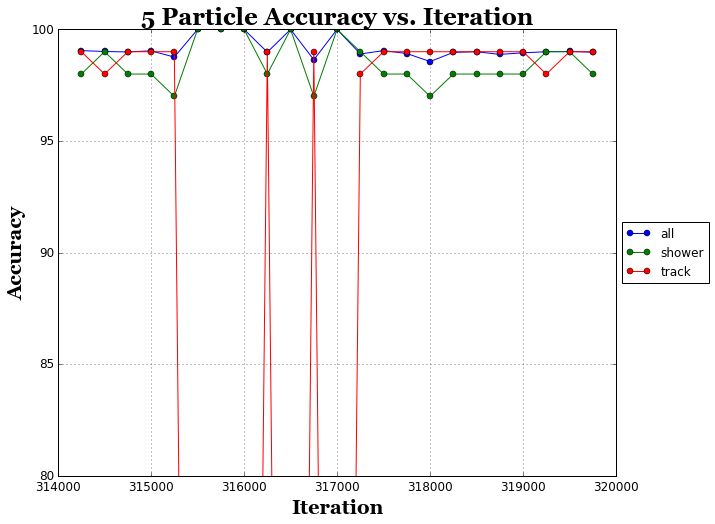

In [5]:
#
# Analyze shower/track
#

#
# Configurations
#
# network name
netname='resnet50b'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['shower','track']
labels = [[0,1], [2,3,4]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(80,100)
plt.show()

Network resnet50b

Iterations [314250, 314500, 314750, 315000, 315250, 315500, 315750, 316000, 316250, 316500, 316750, 317000, 317250, 317500, 317750, 318000, 318250, 318500, 318750, 319000, 319250, 319500, 319750]

Result:
    Iteration  all_combined  eminus  gamma
0      314250         86.30      88     84
1      314500         86.80      84     89
2      314750         85.32      80     89
3      315000         85.98      90     81
4      315250         85.78      88     83
5      315500        100.00       0    100
6      315750        100.00       0    100
7      316000        100.00       0    100
8      316250         86.02      87     84
9      316500        100.00       0    100
10     316750         84.80      84     85
11     317000        100.00       0    100
12     317250         86.26      84     87
13     317500         86.06      86     85
14     317750         85.62      88     82
15     318000         85.02      83     86
16     318250         83.48      93     73
17

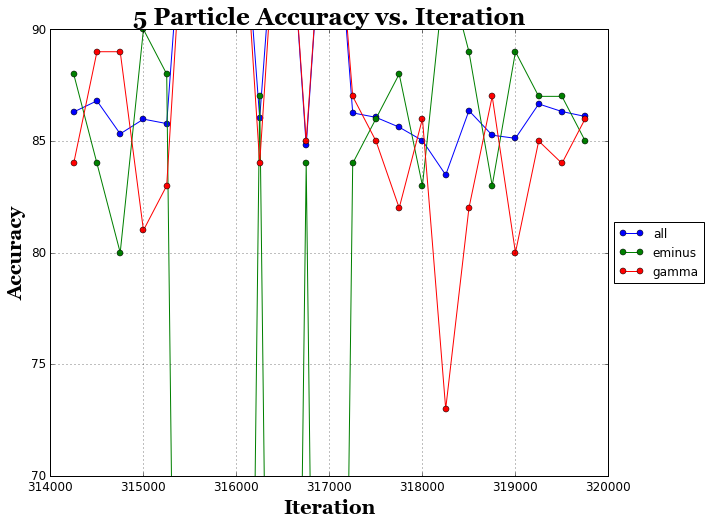

In [6]:
#
# Analyze e/gamma
#

#
# Configurations
#
# network name
netname='resnet50b'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['eminus','gamma']
labels = [[0], [1]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,90)
plt.show()

Network resnet50b

Iterations [314250, 314500, 314750, 315000, 315250, 315500, 315750, 316000, 316250, 316500, 316750, 317000, 317250, 317500, 317750, 318000, 318250, 318500, 318750, 319000, 319250, 319500, 319750]

Result:
    Iteration  all_combined  muminus  piminus
0      314250         84.68       88       80
1      314500         84.28       88       79
2      314750         83.06       92       74
3      315000         84.82       89       79
4      315250         84.92       88       81
5      315500          0.00        0        0
6      315750          0.00        0        0
7      316000          0.00        0        0
8      316250         84.28       95       73
9      316500          0.00        0        0
10     316750         84.70       91       78
11     317000          0.00        0        0
12     317250         82.74       89       75
13     317500         84.38       90       78
14     317750         84.92       89       80
15     318000         82.36       89    

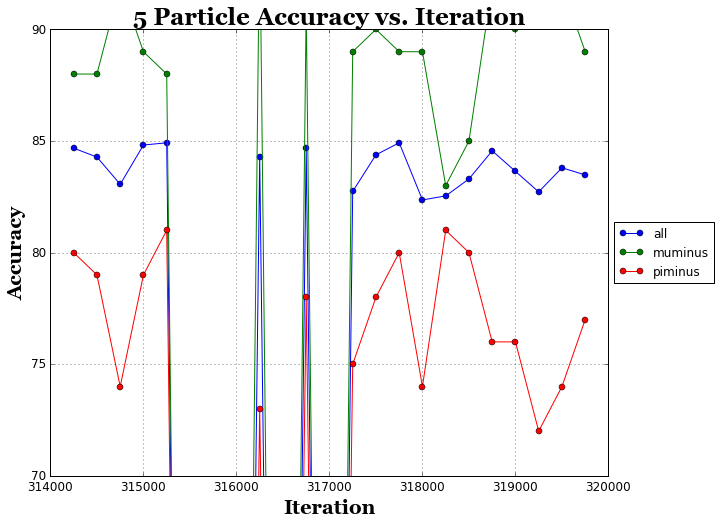

In [7]:
#
# Analyze mu/pi
#

#
# Configurations
#
# network name
netname='resnet50b'

# Report network name
print 'Network',netname
print

# define labels & names
names  = ['muminus','piminus']
labels = [[2], [3]]
res = get_accuracy(netname,names=names, labels=labels)

# print result
print 'Result:'
print res
print

#
# Plot result
#
fig,ax=plt.subplots(figsize=(10,8),facecolor='w')
plt.plot(res.Iteration.values,res.all_combined.values,label='all',marker='o')

cmd = 'plt.plot(res.Iteration.values,res.%s.values,label="%s",marker="o")'
for name in names:
    exec(cmd % (name,name))

leg=plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.get_frame().set_facecolor('white')
plt.xlabel("Iteration",fontsize=20,fontweight='bold',fontname='Georgia')
plt.ylabel("Accuracy",fontsize=20,fontweight='bold',fontname='Georgia')
plt.title('5 Particle Accuracy vs. Iteration',fontsize=24,fontweight='bold',fontname='Georgia')
plt.tick_params(labelsize=12)
plt.grid()
plt.ylim(70,90)
plt.show()